# Toy Autonomous Car


### Build a Traffic Sign Recognition Classifier

In this notebook we will train a deep neural network to recognize traffic signs

---
## Load The Data

In [1]:
# Usual imports
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Load pickled data
import pickle

# Import Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
from scipy.misc import toimage
K.set_image_dim_ordering('th')

# Visualizations will be shown in the notebook.
%matplotlib inline

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./data_train.pickle"
testing_file = "./data_test.pickle"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Load class descriptions
signnames = pd.read_csv("signnames.csv")

print("Data loaded...")

Using TensorFlow backend.


Data loaded...


## Dataset Summary & Exploration

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 1889
Number of testing examples = 600
Image data shape = (1889, 32, 32, 3)
Number of classes = 3


In [3]:
# Display SignNames (class descriptions)
display(signnames)

,ClassId,SignName
0,0,Stop
1,1,Turn right ahead
2,2,Turn left ahead


Let us visualize dataset by plotting an image from each class.

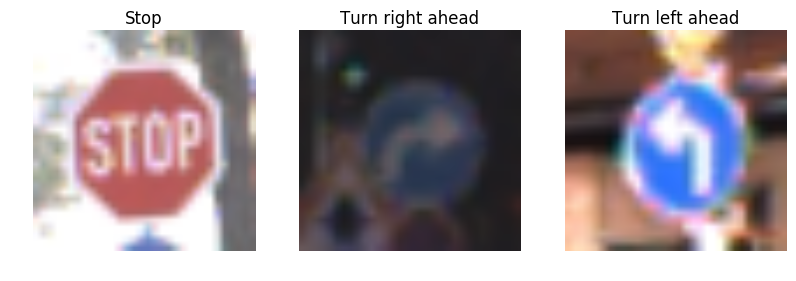

In [4]:
# show an image from each class in a grid
plt.subplots(figsize=(20, 35))
row = 1
col = 1
for i in range(n_classes):
    class_id = np.where(y_train==i)[0][0]
    plt.subplot2grid((10, 6), (row, col)) # we really need 9 x 5 = 45 to cover 43 images. Keep one extra each
    plt.imshow(toimage(X_train[class_id]))
    plt.axis("off")
    title = signnames['SignName'][i]
    plt.title(title)
    
    col += 1
    if(col > 5): 
        col = 1
        row += 1

Let us plot histogram of training labels to visualize if there are any imbalances in class distribution

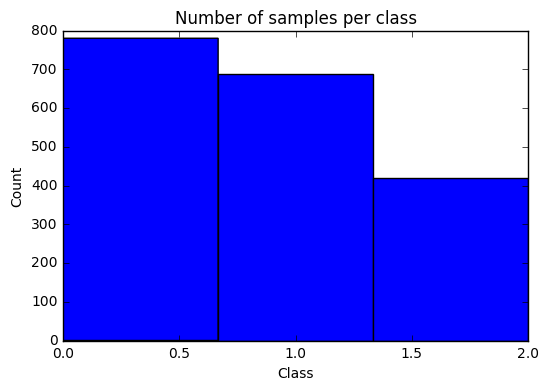

In [5]:
def show_samples_distribution():
    plt.hist(y_train, n_classes)
    plt.title('Number of samples per class')
    plt.xlabel('Class')
    plt.ylabel('Count')
    _ =  plt.show()
    
show_samples_distribution()

There is too much difference between the classes. We are going to create some data to balance the number of inputs and reduce the probable bias the network could have towards some classes. It will also help us give more data to our network.

## Step 2: Design and Test a Model Architecture

Generating additional data...
Finished rotating images


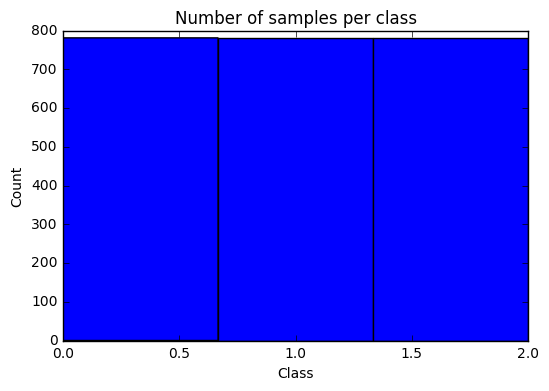

Finished normalizing images
Finished one hot encoding labels
Finished randomizing and splitting dataset into train and validation


In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

print('Generating additional data...')

samples_per_class = np.bincount(y_train)
angles = [-3, 3, -5, 5, -10, 10, -15, 15, -20, 20]

image_cols = X_train.shape[1] # 32 x 32 image
image_rows = X_train.shape[2]

rotated_images = []
rotated_labels = []

# use openCV to rotate images of classes that have few samples

samples_count_in_max_class = max(samples_per_class)
for class_id in range(n_classes):
    samples_count_in_this_class = samples_per_class[class_id]
    shortfall = samples_count_in_max_class - samples_count_in_this_class
    
    image_ids_in_this_class = np.where(y_train == class_id)[0]
    for image_id in image_ids_in_this_class:
        for angle in angles:
            source_image = X_train[image_id]
            rotation_matrix = cv2.getRotationMatrix2D((image_cols/2, image_rows/2), angle, 1)
            rotated_image = cv2.warpAffine(source_image, rotation_matrix, (image_cols, image_rows))
            
            rotated_images.append(rotated_image)
            rotated_labels.append(class_id)
            
            shortfall -= 1
            if(shortfall <= 0): break
            # plt.imshow(toimage(source_image))
            # plt.imshow(toimage(rotated_image))
        if(shortfall <= 0): break

print ("Finished rotating images")

# Concatenate generated data with loaded dataset
X_train = np.append(X_train, rotated_images, axis=0)
y_train = np.append(y_train, rotated_labels, axis=0)

# histogram with augumented data
show_samples_distribution()

# Normalize features from 0-255 to 0.0-1.0
X_train = X_train / 255.0
X_test = X_test / 255.0
print ("Finished normalizing images")

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print ("Finished one hot encoding labels")

# Get randomized datasets for training and validation
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(
   X_train,
   y_train,
   test_size=0.2,
   random_state=7
)
print('Finished randomizing and splitting dataset into train and validation')

Ah! The data looks more balanced now. Let us use it to train our Neural Network Classifier.

## Convolutional Neural Network to classify Traffic Signs

In [7]:
# Create the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile model
epochs = 3
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 3)     9248        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 3)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 3)     9248        dropout_1[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 16, 1)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [8]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), nb_epoch=epochs, batch_size=32)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 1872 samples, validate on 469 samples
Epoch 1/3
1872/1872 [==============================] - 4s - loss: 0.5698 - acc: 0.7361 - val_loss: 0.1143 - val_acc: 0.9915
Epoch 2/3
1872/1872 [==============================] - 1s - loss: 0.0524 - acc: 0.9872 - val_loss: 0.0170 - val_acc: 1.0000
Epoch 3/3
1872/1872 [==============================] - 1s - loss: 0.0182 - acc: 0.9957 - val_loss: 0.0085 - val_acc: 1.0000
Accuracy: 99.83%


We can use the data collected in the history object to create plots.

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


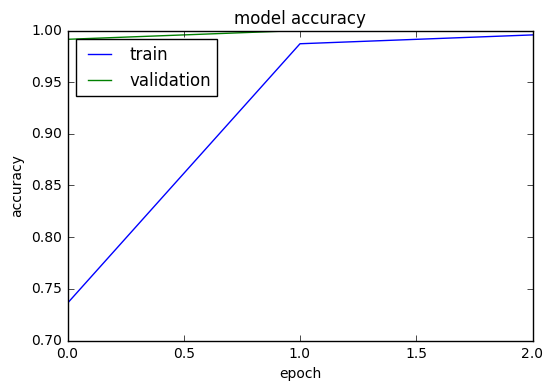

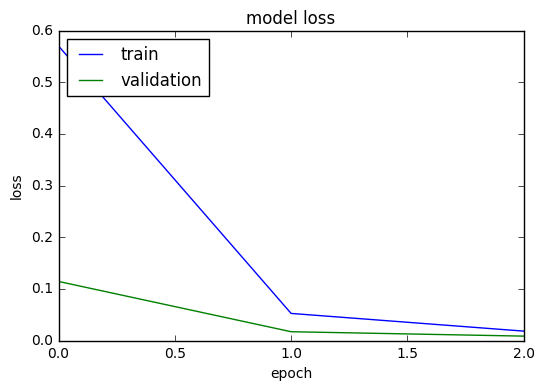

In [9]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Keras separates the concerns of saving your model architecture and saving your model weights.

Model weights are saved to HDF5 format. This is a grid format that is ideal for storing multi-dimensional arrays of numbers.

The model structure can be described and saved using two different formats: JSON and YAML.

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [11]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

predictions = loaded_model.predict(X_test)

Loaded model from disk
Accuracy: 99.83%


In [12]:
import random

# show couple of random images from the given set
def plot_examples(preds, features, labels, show_errors=False):
    
    # reverse one hot encoding
    predicted_labels = np.argmax(np.round(preds), axis=1)
    known_labels = np.argmax(labels, axis=1)
    
    # compare model predictions with known labels
    result = (predicted_labels == known_labels)

    indices = [i for i, x in enumerate(result) if x == (not show_errors)]

    # show an image from each class in a grid
    plt.subplots(figsize=(20, 35))
    for i in range(5):
        
        image_id = random.choice(indices)
        # image_id = indices[i]
        
        plt.subplot(150 + 1 + i)
        plt.imshow(toimage(features[image_id]))
        
        label_id = predicted_labels[image_id]
        predicted_title = signnames['SignName'][label_id]
        
        label_id = known_labels[image_id]
        known_title = signnames['SignName'][label_id]

        plt.title("P: {}".format(predicted_title))
        plt.xlabel("C: {}".format(known_title))

### Examples of correct predictions:

Let us look at couple of images for which our model got correct Predictions. 

Text on the top of the images are the predicted labels, whereas text at the bottom of the imgaes are the true known labels.

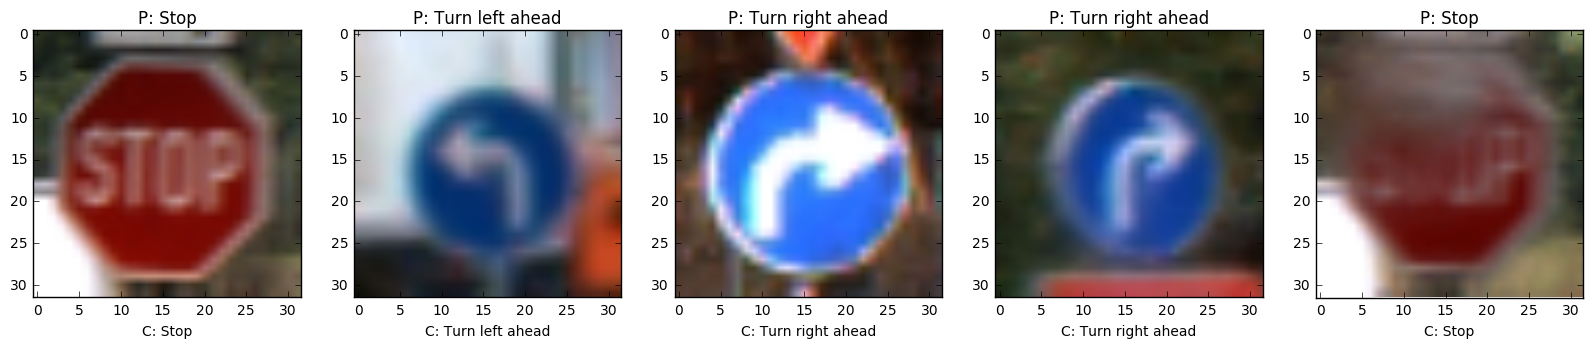

In [13]:
plot_examples(predictions, X_test, y_test, False)